<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span></li><li><span><a href="#Loading-the-data" data-toc-modified-id="Loading-the-data-2">Loading the data</a></span><ul class="toc-item"><li><span><a href="#Load-all-the-data-and-randomly-split-it-into-1500-training-examples-and-500-validation-examples." data-toc-modified-id="Load-all-the-data-and-randomly-split-it-into-1500-training-examples-and-500-validation-examples.-2.1">Load all the data and randomly split it into 1500 training examples and 500 validation examples.</a></span></li></ul></li><li><span><a href="#Sparse-Representations" data-toc-modified-id="Sparse-Representations-3">Sparse Representations</a></span><ul class="toc-item"><li><span><a href="#Function-that-converts-an-example-(e.g.-a-list-of-words)-into-a-sparse-bag-of-words-representation:" data-toc-modified-id="Function-that-converts-an-example-(e.g.-a-list-of-words)-into-a-sparse-bag-of-words-representation:-3.1">Function that converts an example (e.g. a list of words) into a sparse bag-of-words representation:</a></span></li></ul></li><li><span><a href="#Support-Vector-Machine-via-Pegasos" data-toc-modified-id="Support-Vector-Machine-via-Pegasos-4">Support Vector Machine via Pegasos</a></span><ul class="toc-item"><li><span><a href="#Pegasos-algorithm" data-toc-modified-id="Pegasos-algorithm-4.1">Pegasos algorithm</a></span></li><li><span><a href="#Support-Vector-Machine-(SVM)" data-toc-modified-id="Support-Vector-Machine-(SVM)-4.2">Support Vector Machine (SVM)</a></span></li><li><span><a href="#Implementation-of-the-Pegasos-algorithm-to-run-on-a-sparse-data-representation" data-toc-modified-id="Implementation-of-the-Pegasos-algorithm-to-run-on-a-sparse-data-representation-4.3">Implementation of the Pegasos algorithm to run on a sparse data representation</a></span><ul class="toc-item"><li><span><a href="#Version-1" data-toc-modified-id="Version-1-4.3.1">Version 1</a></span></li><li><span><a href="#Version-2" data-toc-modified-id="Version-2-4.3.2">Version 2</a></span></li></ul></li><li><span><a href="#Comparison-of-the-two-approaches" data-toc-modified-id="Comparison-of-the-two-approaches-4.4">Comparison of the two approaches</a></span></li><li><span><a href="#Loss-function" data-toc-modified-id="Loss-function-4.5">Loss function</a></span></li><li><span><a href="#Regularization-parameter-optimization" data-toc-modified-id="Regularization-parameter-optimization-4.6">Regularization parameter optimization</a></span></li><li><span><a href="#Score" data-toc-modified-id="Score-4.7">Score</a></span></li><li><span><a href="#Differentiability" data-toc-modified-id="Differentiability-4.8">Differentiability</a></span></li></ul></li><li><span><a href="#Error-analysis" data-toc-modified-id="Error-analysis-5">Error analysis</a></span></li><li><span><a href="#Features" data-toc-modified-id="Features-6">Features</a></span><ul class="toc-item"><li><span><a href="#Stopwords" data-toc-modified-id="Stopwords-6.1">Stopwords</a></span></li><li><span><a href="#Loss-function-with-standard-error" data-toc-modified-id="Loss-function-with-standard-error-6.2">Loss function with standard error</a></span></li><li><span><a href="#Other-ideas-for-new-features:" data-toc-modified-id="Other-ideas-for-new-features:-6.3">Other ideas for new features:</a></span></li></ul></li></ul></div>

# Homework 3: SVM and Sentiment Analysis

Assignment for the [Foundations of Machine Learning](https://bloomberg.github.io/foml/#about) course.
The assignment text can be found [here]()

## Introduction

- Goal of the assignment: perform sentiment analysis on movie reviews. We will be working with **natural language data**. 
- First, the **Pegasos algorithm** is implemented. Pegasos is essentially stochastic subgradient descent for the SVM with a particular schedule for the step-size.
- Second, because in natural language domains we typically have huge feature spaces, we work with **sparse representations** of feature vectors, where only the non-zero entries are explicitly recorded. This will require coding the gradient and SGD code using hash tables (dictionaries in Python), rather than numpy arrays.
- Then we will perform feature engineering to improve our model.

## Loading the data

- We will be using the [Polarity Dataset v2.0](https://www.cs.cornell.edu/people/pabo/movie-review-data/), constructed by Pang and Lee. 
- It has the full text from 2000 movies reviews: 1000 reviews are classified as “positive” and 1000 as “negative.” - Our goal is to predict whether a review has positive or negative sentiment from the text of the review. 
- Each review is stored in a separate file: the positive reviews are in a folder called “pos”, and the negative reviews are in “neg”. 

### Load all the data and randomly split it into 1500 training examples and 500 validation examples.

In [1]:
################################Code provided in the assignment###################################################
import os
import numpy as np
import pickle
import random

'''
Note:  This code is just a hint for people who are not familiar with text processing in python. 
There is no obligation to use this code, though you may if you like. 
'''


def folder_list(path,label):
    '''
    PARAMETER PATH IS THE PATH OF YOUR LOCAL FOLDER
    '''
    filelist = os.listdir(path)
    review = []
    for infile in filelist:
        file = os.path.join(path,infile)
        r = read_data(file)
        r.append(label)
        review.append(r)
    return review

def read_data(file):
    '''
    Read each file into a list of strings. 
    Example:
    ["it's", 'a', 'curious', 'thing', "i've", 'found', 'that', 'when', 'willis', 'is', 'not', 'called', 'on', 
    ...'to', 'carry', 'the', 'whole', 'movie', "he's", 'much', 'better', 'and', 'so', 'is', 'the', 'movie']
    '''
    f = open(file)
    lines = f.read().split(' ') #split each line on whitespace
    symbols = '${}()[].,:;+-*/&|<>=~" '
    words = map(lambda Element: Element.translate(str.maketrans("", "", symbols)).strip(), lines)
    words = filter(None, words)
    list_words = list(words)
    return list_words

###############################################
######## YOUR CODE STARTS FROM HERE. ##########
###############################################

def shuffle_data():
    '''
    pos_path is where you save positive review data.
    neg_path is where you save negative review data.
    '''
    pos_path = '/Users/Coline/Desktop/mlprojects/Bloomberg_foundations_of_ML/hw3-svm/data/pos'
    neg_path = '/Users/Coline/Desktop/mlprojects/Bloomberg_foundations_of_ML/hw3-svm/data/neg'

    #pos_path = r"H:\Ny mapp\Literature\Bayesian prob\Bloomsberg lectures\Week8\hw3\data\data\pos"
    #neg_path = r"H:\Ny mapp\Literature\Bayesian prob\Bloomsberg lectures\Week8\hw3\data\data\neg"
    
    pos_review = folder_list(pos_path,1)
    neg_review = folder_list(neg_path,-1)

    review = pos_review + neg_review
    random.shuffle(review)
  
    '''
    Now you have read all the files into list 'review' and it has been shuffled.
    Save your shuffled result by pickle.
    *Pickle is a useful module to serialize a python object structure. 
    *Check it out. https://wiki.python.org/moin/UsingPickle
    '''
    train = review[:1500]
    valid = review[1500:]
    
    with open('train.pkl', 'wb') as f:
        pickle.dump(train, f)
    
    with open('valid.pkl', 'wb') as f:
        pickle.dump(valid, f)
    
    return train, valid

In [2]:
train, valid = shuffle_data()

In [3]:
#load files from memory
with open('train.pkl', 'rb') as f:
    train = pickle.load(f)
with open('valid.pkl', 'rb') as f:
    valid = pickle.load(f)

## Sparse Representations

- The most basic way to represent text documents for machine learning is with a **“bag-of-words”** representation. 
- Here every possible word is a feature, and the value of a word feature is the number of times that word appears in the document. Of course, most words will not appear in any particular document, and those counts will be zero. 
- Rather than store a huge number of zeros, we use a **sparse representation**, in which we only store the counts that are nonzero. The counts are stored in a key/value store (such as a dictionary in Python).  
For example, “Harry Potter and Harry Potter II” would be represented as the following Python dict: ``x={’Harry’:2, ’Potter’:2, ’and’:1, ’II’:1}``.  
- We will be using linear classifiers of the form $f(x) = w^T x$, and we can store the $w$ vector in a sparse format as well, such as ``w={’minimal’:1.3, ’Harry’:-1.1, ’viable’:-4.2, ’and’:2.2, ’product’:9.1}``. 
- The inner product between $w$ and $x$ would only involve the features that appear in both $x$ and $w$, since whatever doesn’t appear is assumed to be zero. For this example, the inner product would be ``x[Harry] * w[Harry] + x[and] * w[and] = 2*(-1.1) + 1*(2.2)``.  

### Function that converts an example (e.g. a list of words) into a sparse bag-of-words representation:

In [4]:
from collections import Counter

def bag_of_words(review):
    '''
    Converts a list of words into a sparse bag-of-words representation.
    @Param review: list (iterable)
    Returns a dictionary with keys=words and values=number of times the words appear
    '''
    cnt = Counter()
    for word in review:
        cnt[word] += 1
    return cnt

## Support Vector Machine via Pegasos

In this question you will build an SVM using the Pegasos algorithm. To align with the notation used in the [Pegasos paper](https://ttic.uchicago.edu/~nati/Publications/PegasosMPB.pdf), we’re considering the following formulation of the SVM objective function: $$ min_{w \in R^d} \frac{\lambda}{2} + \frac{1}{m} \sum_{i=1}^m max\{0, 1-y_iw^Tx_i\} $$

Note that, for simplicity, we are leaving off the unregularized bias term $b$. 

### Pegasos algorithm
Pegasos is stochastic subgradient descent using a step size rule $\eta_t = \frac{1}{\lambda t}$. The pseudocode is given below:

***
Input: $\lambda > 0$. Choose $w_1 = 0; t = 0$

While termination condition not met  

&nbsp;&nbsp;For $j = 1,...,m$ (assumes data is randomly permuted)  

&nbsp;&nbsp;&nbsp;&nbsp;$t = t + 1$  

&nbsp;&nbsp;&nbsp;&nbsp;$\eta_t = \frac{1}{t\lambda}$;  

&nbsp;&nbsp;&nbsp;&nbsp;If $y_j w^T_t x_j < 1$  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$w_{t+1} = (1 - \eta_t \lambda)w_t + \eta_t y_j x_j$  

&nbsp;&nbsp;&nbsp;&nbsp;Else  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$w_{t+1} = (1 - \eta_t \lambda)w_t$ 
***

### Support Vector Machine (SVM)
The “stochastic” SVM objective function is the SVM objective function with a single training point:  
  
$$J_i(w) = \frac{\lambda}{2} \|w\|^2 + max\{0, 1-y_iw^Tx_i\}$$   
The function  $J_i(w)$ is not differentiable at $y_i w^T x_i = 1$ .

A subgradient of $J_i(w)$ is given by 

$$ g =
  \begin{cases}
    \lambda w - y_i x_i       & \quad \text{for } y_i w^T x_i < 1 \\
    \lambda w  & \quad \text{for } y_i w^T x_i \geq 1
  \end{cases}
$$

If the step size rule is $\eta_t = \frac{1}{\lambda t}$, then doing SGD with the subgradient direction from the previous problem is the same as given in the pseudocode.

### Implementation of the Pegasos algorithm to run on a sparse data representation

In [5]:
#########################################code given in the assignment#############################################
# Taken from http://web.stanford.edu/class/cs221/ Assignment #2 Support Code

def dotProduct(d1, d2):
    """
    @param dict d1: a feature vector represented by a mapping from a feature (string) to a weight (float).
    @param dict d2: same as d1
    @return float: the dot product between d1 and d2
    """
    if len(d1) < len(d2):
        return dotProduct(d2, d1)
    else:
        return sum(d1.get(f, 0) * v for f, v in d2.items())

def increment(d1, scale, d2):
    """
    Implements d1 += scale * d2 for sparse vectors.
    @param dict d1: the feature vector which is mutated.
    @param float scale
    @param dict d2: a feature vector.

    NOTE: This function does not return anything, but rather
    increments d1 in place. We do this because it is much faster to
    change elements of d1 in place than to build a new dictionary and
    return it.
    """
    for f, v in d2.items():
        d1[f] = d1.get(f, 0) + v * scale
        
#########################################end of code given in the assignment#####################################

#### Version 1

In [6]:
def pegasos(train, epoch, l_reg=0.1):
    '''
    Implements Pegasos algorithm running on sparse data representation. 
    @param train: list of lists, each list contains single words from the review
    @param epoch: number of epochs, integer
    @param l_reg: regularization parameter lambda, float
    
    The weight dictionnary w is initialized as an empty dictionnary. 
    For each epoch, the algorithm passes through each datapoint of the randomized dataset and the step size 
    is decreased by a factor of 1/t (t increments after each datapoint).
    Each datapoint is transformed into a bag of words using the bag_of_words function, and the label y_j is 
    extracted. The gradient is calculated using the appropriate subgradient, defined by the value of the
    margin (calculated using the dotProduct function). The weight dictionnary is updated with the gradient
    and step size using the increment function.
    '''
    w = {}
    t = 0

    for i in range(epoch):
        
        if i%10 == 0:
            print("Epoch: {}".format(i))
        
        for j in range(len(train)):
            t = t+1
            step = 1/(l_reg*t)
            x_j = bag_of_words(train[j][:-1])
            y_j = train[j][-1]                   #The label is the last entry in the list
            margin = y_j*dotProduct(w,x_j)
        
            if margin < 1:
                increment(w, -step*l_reg, w)
                increment(w, step*y_j, x_j)
            
            else:
                increment(w, -step*l_reg, w)
        
    return w

In [7]:
w1 = pegasos(train, epoch=2, l_reg=0.01)

Epoch: 0


#### Version 2

- Note that in every step of the Pegasos algorithm, we rescale every entry of $w_t$ by the factor $(1 − \eta_t \lambda)$. 
- Implementing this directly with dictionaries is very slow. 
- We can make things significantly faster by representing $w$ as $w = sW$, where $s \in R$ and $W \in R^d$. 
- You can start with $s = 1$ and $W$ all zeros (i.e. an empty dictionary). Note that both updates (i.e. whether or not we have a margin error) start with rescaling $w_t$, which we can do simply by setting $s_{t+1} = (1 − \eta_t \lambda)s_t$. If the update is $w_{t+1} = (1 − \eta_t \lambda)w_t + \eta_t y_j x_j$, then **verify that the Pegasos update step is equivalent to**:  

$$s_{t+1} = (1 − \eta_t \lambda)s_t$$
$$W_{t+1} = W_t + \frac{1}{s_{t+1}} \eta_t y_j x_j.$$

There is one subtle issue with the approach described above: if we ever have $1 − \eta_t \lambda = 0$, then $s_{t+1} = 0$, and we’ll have a divide by 0 in the calculation for $W_{t+1}$. This only happens when $\eta_t = 1/\lambda$. With our step-size rule of $\eta_t = 1/\lambda t$, it happens exactly when $t = 1$. So one approach is to just start at $t = 2$. More generically, note that if $s_{t+1} = 0$, then $w_{t+1} = 0$. Thus an equivalent representation is $s_{t+1} = 1$ and $W = 0$. Thus if we ever get $s_{t+1} = 0$, simply set it back to 1 and reset $W_{t+1}$ to zero, which is an empty dictionary in a sparse representation.  
Implement the Pegasos algorithm with the $(s, W)$ representation described above. [See section 5.1 of Leon Bottou’s Stochastic Gradient Tricks for a more generic version of this technique, and many other useful tricks.]

In [9]:
def pegasos_v2(train, valid, epoch, l_reg=0.1, tol=1e-9):
    '''
    pegasos_v2 function implements Pegasos algorithm running on sparse data representation. 
    @param train: list of lists, each list contains single words from the review. Training set
    @param valid: list of lists, each list contains single words from the review. Validation set
    @param epoch: number of epochs, integer
    @param l_reg: regularization parameter lambda, float
    @param tol: tolerance level for estimation of convergence, float
    
    The weight dictionnary w is represented as w=sW, where s in is R and W is in Rd. 
    The parameters initialization is s=1 and W empty dictionary.
    '''
    s = 1
    W = {}
    t = 1
    w = {}

    for i in range(epoch):
         
        #Storing the weight vector to perform estimation of convergence after each epoch
        w_old = W.copy() 
        for a,b in w_old.items():
            w_old[a] = b*s_new

        for j in range(len(train)):
            t = t+1
            step = 1/(l_reg*t)
            x_j = bag_of_words(train[j][:-1])
            y_j = train[j][-1]
             
            margin = s*y_j*dotProduct(W,x_j)
            
            if margin < 1:
                s_new = s*(1-step*l_reg)
                increment(W, (step*y_j)/s_new, x_j)
                s = s_new
            
            else:
                s_new = s*(1-step*l_reg)
                s = s_new    
            
        
        if i%100 == 0:
            print("Epoch: {}".format(i))
            w = W.copy()
            for a,b in w.items():
                w[a] = b*s_new
            loss_val = loss(valid,w)
            print('The model classified {}% of the examples correctly'.format(loss_val))
        
        #Testing for convergence:
        if i != 0: 
            list_weights_diff = []
            w = W.copy()
            for a,b in w.items():
                w[a] = b*s_new
            for k, v in w_old.items():
                list_weights_diff.append(np.abs(w.get(k, 0) - w_old[k])) 
        
            if np.all(np.asarray(list_weights_diff) < tol):
                print('converged')
                break   
    return w

### Comparison of the two approaches

In [10]:
%time w1 = pegasos(train, epoch=2, l_reg=0.01)

Epoch: 0
CPU times: user 23.3 s, sys: 163 ms, total: 23.4 s
Wall time: 23.8 s


In [11]:
%time w2 = pegasos_v2(train, valid, epoch=2, l_reg=0.01)

Epoch: 0
The model classified 63.6% of the examples correctly
CPU times: user 1.61 s, sys: 15.4 ms, total: 1.63 s
Wall time: 1.63 s


In [12]:
loss(valid, w1)

62.4

In [13]:
loss(valid, w2)

62.4

In [14]:
#Looking at the content of the weight dicts:
list_weights_diff = []
for k, v in w1.items():
    list_weights_diff.append(np.abs(w2.get(k, 0) - w1[k]))
np.all(np.asarray(list_weights_diff) < 1e-2)

True

- When expressing the vector $w_t$ as the product $s_tW_t$, where s is a scalar, as was done in pegasos_v2 algorithm, the algorithm is sped up by a factor of 14, which is significantly faster.
- The performance of the algorithms was equivalent: they had the same classification error on the training set, and the weight vectors were very similar.
- In the rest of this assignement, I will use pegasos_v2

### Loss function

In [8]:
def loss(valid, w):
    '''
    function that takes a sparse weight vector w and a collection of (x,y) pairs,
    and returns the percent error when predicting y using sign(w^Tx). 
    In other words, the function reports the 0-1 loss of the linear predictor x -> w^Tx.
    '''
    count = 0
    for i in range(len(valid)):
        y_i = valid[i][-1]
        x_i = bag_of_words(valid[i][:-1])
        pred = dotProduct(w,x_i)
        
        if (pred/y_i) > 0: #occurs when y_i and w^Tx_i have the same sign (ie correct prediction)
            count += 1
            
    percent = (count/(len(valid)))*100
    
    return percent

### Regularization parameter optimization

- Using the bag-of-words feature representation described above, search for the regularization parameter that gives the minimal percent error on your test set. 
- Using the faster Pegasos implementation, running to convergence. 

In [15]:
#Range of lambda values
l_reg_arr = np.unique(np.concatenate((10.**np.arange(-6,1,1), np.arange(1,3,.3))))

#Initialize values
w_history = []
loss_history = []

#Run SVM algo for each lambda
for l_reg in l_reg_arr:
    w = pegasos_v2(train, valid, epoch=250, l_reg=l_reg, tol=1e-2)
    w_history.append(w)
    
    #Calculate misclassification percentage for each lambda
    loss_val = 100-loss(valid, w)
    loss_history.append(loss_val)

Epoch: 0
The model classified 51.0% of the examples correctly
Epoch: 100
The model classified 81.6% of the examples correctly
Epoch: 200
The model classified 81.6% of the examples correctly
Epoch: 0
The model classified 51.0% of the examples correctly
Epoch: 100
The model classified 81.6% of the examples correctly
Epoch: 200
The model classified 79.60000000000001% of the examples correctly
Epoch: 0
The model classified 51.0% of the examples correctly
Epoch: 100
The model classified 82.19999999999999% of the examples correctly
Epoch: 200
The model classified 82.19999999999999% of the examples correctly
Epoch: 0
The model classified 51.0% of the examples correctly
Epoch: 100
The model classified 80.2% of the examples correctly
converged
Epoch: 0
The model classified 63.6% of the examples correctly
converged
Epoch: 0
The model classified 69.19999999999999% of the examples correctly
converged
Epoch: 0
The model classified 57.4% of the examples correctly
converged
Epoch: 0
The model classif

In [16]:
#Present the results in a table
import pandas as pd
df_error = pd.DataFrame({'Param_l_reg': l_reg_arr, 'Classification error': loss_history})

print(df_error)

min_idx = df_error['Classification error'].idxmin()
print('The regression parameter that minimizes test loss was {:.2e}.'.format(df_error['Param_l_reg'][min_idx]))

    Param_l_reg  Classification error
0      0.000001                  18.4
1      0.000010                  18.6
2      0.000100                  17.8
3      0.001000                  18.4
4      0.010000                  18.2
5      0.100000                  18.0
6      1.000000                  24.4
7      1.300000                  23.4
8      1.600000                  25.0
9      1.900000                  24.6
10     2.200000                  26.2
11     2.500000                  25.6
12     2.800000                  27.0
The regression parameter that minimizes test loss was 1.00e-04.


Text(0, 0.5, 'Classification error')

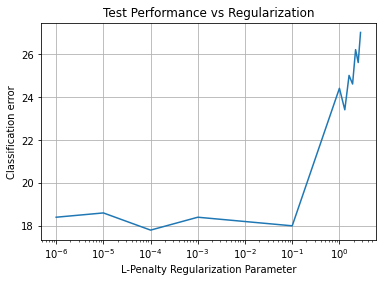

In [17]:
import matplotlib.pyplot as plt
# Plot validation performance vs regularization parameter
fig, ax = plt.subplots()

ax.semilogx(df_error["Param_l_reg"], df_error["Classification error"])
ax.grid()
ax.set_title("Test Performance vs Regularization")
ax.set_xlabel("L-Penalty Regularization Parameter")
ax.set_ylabel("Classification error")

In summary, the regularization parameters in the range [1e-4,1e-2] achieved the best performance for the model.

### Score

Score is the value of the prediction $f(x) = w^Tx$  
Does the magnitude of the score represent the confidence of the prediction?

In [18]:
#Run pegasos_v2 with optimized regularization parameter
w = pegasos_v2(train, valid, epoch=250, l_reg=1e-2, tol=1e-2)

#Initiate arrays to store the score and error for each example
score = np.zeros(len(valid))
error = np.zeros(len(valid))

for i in range(len(valid)):
    y_i = valid[i][-1]
    x_i = bag_of_words(valid[i][:-1])
    score[i] = dotProduct(w,x_i)
    if (score[i]/y_i) > 0:
        error[i] = 0
    else:
        error[i] = 1 

score_df = pd.DataFrame({'score':score, 'error': error})

Epoch: 0
The model classified 63.6% of the examples correctly
converged


In [19]:
#Divide the scores in groups of equal size
quantiles = pd.qcut(score_df['score'], 10)

#Function returning the count of elements in each group and the sum of errors
def get_stats(group):
    return {'count': group.count(), 'sum': group.sum()}

#Group the dataset and apply the count and sum
grouped = score_df['error'].groupby(quantiles)

df = grouped.apply(get_stats).unstack()

df['error ratio (%)'] = (df['sum']/df['count'])*100
df

,count,sum,error ratio (%)
score,,,
"(-10.318999999999999, -3.678]",50.0,2.0,4.0
"(-3.678, -2.695]",50.0,4.0,8.0
"(-2.695, -1.715]",50.0,7.0,14.0
"(-1.715, -0.957]",50.0,15.0,30.0
"(-0.957, -0.216]",50.0,19.0,38.0
"(-0.216, 0.491]",50.0,26.0,52.0
"(0.491, 1.325]",50.0,10.0,20.0
"(1.325, 2.175]",50.0,6.0,12.0
"(2.175, 3.712]",50.0,2.0,4.0


In [20]:
#Divide the scores in groups of different size but more meaningful bins
bins = [-50, -2,0,1,2, 50]
cats = pd.cut(score_df['score'], bins, right=False)
grouped2 = score_df['error'].groupby(cats)
df2 = grouped2.apply(get_stats).unstack()
df2['error ratio (%)'] = (df2['sum']/df2['count'])*100
df2

,count,sum,error ratio (%)
score,,,
"[-50, -2)",132.0,8.0,6.060606
"[-2, 0)",132.0,47.0,35.606061
"[0, 1)",72.0,28.0,38.888889
"[1, 2)",50.0,5.0,10.000000
"[2, 50)",114.0,3.0,2.631579


Groups with small score amplitude (score in [-2,2)) have the highest error ratio. Higher magnitude scores lead to higher accuracy.

### Differentiability

- The objective function is not differentiable when $y_iw^Tx_i = 1$. 
- How often and when do we have  $y_iw^Tx_i = 1$ (or perhaps within a small distance of 1)
- If we didn’t know about subgradients, one might suggest just skipping the update when  $y_iw^Tx_i = 1$. Does this seem reasonable? What about shortening the step size by a small percentage?

In [21]:
#Modified pegasos algo that counts the frequency of yiwTxi close to 1 

def pegasos_v3(train, valid, epoch, l_reg=0.01, tol=1e-9):
    '''
    pegasos_v3 function implements Pegasos algorithm running on sparse data representation. 
    @param train: list of lists, each list contains single words from the review. Training set
    @param valid: list of lists, each list contains single words from the review. Validation set
    @param epoch: number of epochs, integer
    @param l_reg: regularization parameter lambda, float
    @param tol: tolerance level for estimation of convergence, float
    
    The weight dictionnary w is represented as w=sW, where s in is R and W is in Rd. 
    The parameters initialization is s=1 and W empty dictionary.
    '''
    s = 1
    W = {}
    t = 1
    w = {}
    cnt = 0

    for i in range(epoch):
         
        #Storing the weight vector to perform estimation of convergence after each epoch
        w_old = W.copy() 
        for a,b in w_old.items():
            w_old[a] = b*s_new

        for j in range(len(train)):
            t = t+1
            step = 1/(l_reg*t)
            x_j = bag_of_words(train[j][:-1])
            y_j = train[j][-1]
             
            margin = s*y_j*dotProduct(W,x_j)
            
            diff = np.abs(1-margin)
            if diff < 1e-2:
                cnt += 1
            
            if margin < 1:
                s_new = s*(1-step*l_reg)
                increment(W, (step*y_j)/s_new, x_j)
                s = s_new
            
            else:
                s_new = s*(1-step*l_reg)
                s = s_new    
            
        
        if i%100 == 0:
            print("Epoch: {}".format(i))
            w = W.copy()
            for a,b in w.items():
                w[a] = b*s_new
            loss_val = loss(valid,w)
            print('The model classified {}% of the examples correctly'.format(loss_val))
        
        #Testing for convergence:
        if i != 0: 
            list_weights_diff = []
            w = W.copy()
            for a,b in w.items():
                w[a] = b*s_new
            for k, v in w_old.items():
                list_weights_diff.append(np.abs(w.get(k, 0) - w_old[k])) 
        
            if np.all(np.asarray(list_weights_diff) < tol):
                print('converged')
                break   
    return w, i, cnt

In [22]:
w, epoch, cnt = pegasos_v3(train, valid, epoch=300, l_reg=0.01, tol=1e-5)

Epoch: 0
The model classified 63.6% of the examples correctly
Epoch: 100
The model classified 82.0% of the examples correctly
Epoch: 200
The model classified 81.8% of the examples correctly


In [23]:
frequency = (cnt / (epoch * len(train)))*100

print("There were {0} occurences of the margin being close to 1 (tolerance 1e-2), while we cycled {1} times through {2} training examples, which corresponds to a frequency of {3:.2f} %".format(cnt,epoch+1, len(train), frequency))

There were 1976 occurences of the margin being close to 1 (tolerance 1e-2), while we cycled 300 times through 1500 training examples, which corresponds to a frequency of 0.44 %


## Error analysis

Why does the model get results wrong? Detailed analysis of two examples:

In [24]:
#Make a list of indices corresponding to inputs that were predicted wrong:

list_idx = []
for i in range(len(valid)):
    y_i = valid[i][-1]
    x_i = bag_of_words(valid[i][:-1])
    pred = dotProduct(w,x_i)
    if pred/y_i < 0:
        list_idx.append(i)
list_idx[:20]

[0,
 1,
 14,
 15,
 19,
 40,
 46,
 58,
 65,
 83,
 97,
 98,
 106,
 114,
 122,
 128,
 129,
 134,
 137,
 143]

In [25]:
#Pick example that had wrong prediction:

fel_example = bag_of_words(valid[376][:-1])
y = valid[376][-1]

#initialize empty lists
score = []
weight = []
feature_value = []
feature_name = []

for f,v in fel_example.items():
    score.append(np.abs(w.get(f,0)*v))
    weight.append(w.get(f,0))
    feature_value.append(v)
    feature_name.append(f)
    
error_df = pd.DataFrame({'score':score, 'weight': weight, 'feature_value': feature_value, 'feature_name': feature_name})
error_df.sort_values(by=['score'], inplace=True, ascending = False)
error_df.head(10)

,score,weight,feature_value,feature_name
36,0.421332,0.052667,8,he
149,0.351110,0.087778,4,see
20,0.343999,0.038222,9,and
25,0.291555,0.036444,8,it's
70,0.272222,-0.038889,7,this
10,0.267555,0.009556,28,the
111,0.256888,-0.128444,2,nothing
7,0.247777,-0.049555,5,action
49,0.236444,-0.016889,14,to
82,0.222444,-0.020222,11,a


In [26]:
#Pick example that had wrong prediction:

fel_example = bag_of_words(valid[35][:-1])
y = valid[35][-1]

#initialize empty lists
score = []
weight = []
feature_value = []
feature_name = []

for f,v in fel_example.items():
    score.append(np.abs(w.get(f,0)*v))
    weight.append(w.get(f,0))
    feature_value.append(v)
    feature_name.append(f)
    
error_df = pd.DataFrame({'score':score, 'weight': weight, 'feature_value': feature_value, 'feature_name': feature_name})
error_df.sort_values(by=['score'], inplace=True, ascending = False)
error_df.head(10)

,score,weight,feature_value,feature_name
52,0.808887,-0.020222,40,a
29,0.802665,0.038222,21,and
0,0.554221,0.009556,58,the
19,0.345999,-0.038444,9,on
235,0.315999,-0.158000,2,only
49,0.288888,0.022222,13,with
68,0.263111,0.016444,16,is
138,0.249333,0.083111,3,brilliant
101,0.230444,0.013556,17,that
191,0.212444,-0.053111,4,hero


It seems that the features that have the highest score are associated with features that are repeated a lot, such as: 'and', 'the', 'of', 'is', 'in'. They are articles and prepositions and are not very informative.  
There are lists of stopwords in english that can be used to remove these words from the input.

## Features
- Construct new features to improve the performance
- Use new loss function with standard error to evaluate statistical significance of improvements achieved by using new features

### Stopwords

In [27]:
import nltk
#nltk.download()
from nltk.corpus import stopwords
sw = stopwords.words("english")

In [30]:
import os
import numpy as np
import pickle
import random

def folder_list(path,label):
    '''
    PARAMETER PATH IS THE PATH OF YOUR LOCAL FOLDER
    '''
    filelist = os.listdir(path)
    review = []
    for infile in filelist:
        file = os.path.join(path,infile)
        r = read_data(file)
        r.append(label)
        review.append(r)
    return review


def read_data(file):
    '''
    Read each file into a list of strings. Remove stopwords.
    Example:
    ["it's", 'a', 'curious', 'thing', "i've", 'found', 'that', 'when', 'willis', 'is', 'not', 'called', 'on', 
    ...'to', 'carry', 'the', 'whole', 'movie', "he's", 'much', 'better', 'and', 'so', 'is', 'the', 'movie']
    'the' 'a' etc will be removed.
    '''
    f = open(file)
    lines = f.read().split(' ') #split each line on whitespace
    
    symbols = '${}()[].,:;+-*/&|<>=~" '
    words = map(lambda Element: Element.translate(str.maketrans("", "", symbols)).strip(), lines)
    words = filter(None, words)
    list_words = list(words)
    
    #Filter using a stopword list
    sw = stopwords.words("english")
    filtered_words = [word for word in list_words if word not in sw]
    
    return filtered_words


def shuffle_data_v2():
    '''
    pos_path is where you save positive review data.
    neg_path is where you save negative review data.
    '''
    pos_path = '/Users/Coline/Desktop/mlprojects/Bloomberg_foundations_of_ML/hw3-svm/data/pos'
    neg_path = '/Users/Coline/Desktop/mlprojects/Bloomberg_foundations_of_ML/hw3-svm/data/neg'

    #pos_path = r"H:\Ny mapp\Literature\Bayesian prob\Bloomsberg lectures\Week8\hw3\data\data\pos"
    #neg_path = r"H:\Ny mapp\Literature\Bayesian prob\Bloomsberg lectures\Week8\hw3\data\data\neg"
    
    pos_review = folder_list(pos_path,1)
    neg_review = folder_list(neg_path,-1)

    review = pos_review + neg_review
    random.shuffle(review)
  
    train = review[:1500]
    valid = review[1500:]
    
    with open('train_filter.pkl', 'wb') as f:
        pickle.dump(train, f)
    
    with open('valid_filter.pkl', 'wb') as f:
        pickle.dump(valid, f)
    
    return train, valid

In [31]:
train, valid = shuffle_data_v2()

In [32]:
#load files from memory
with open('train_filter.pkl', 'rb') as f:
    train = pickle.load(f)
with open('valid_filter.pkl', 'rb') as f:
    valid = pickle.load(f)

In [33]:
w_filter = pegasos_v2(train, valid, epoch=250, l_reg=1e-2, tol=1e-2)

Epoch: 0
The model classified 79.0% of the examples correctly
converged


In [35]:
loss(valid, w_filter)

84.6

Using stopwords filter improved the performance of the model.

In [36]:
list_idx = []
for i in range(len(valid)):
    y_i = valid[i][-1]
    x_i = bag_of_words(valid[i][:-1])
    pred = dotProduct(w_filter,x_i)
    if pred/y_i < 0:
        list_idx.append(i)
list_idx[:20]

[11,
 15,
 24,
 27,
 28,
 38,
 40,
 43,
 46,
 50,
 53,
 63,
 69,
 73,
 78,
 86,
 94,
 98,
 107,
 113]

In [38]:
#Pick example that had wrong prediction:

fel_example = bag_of_words(valid[113][:-1])
y = valid[113][-1]

#initialize empty lists
score = []
weight = []
feature_value = []
feature_name = []

for f,v in fel_example.items():
    score.append(np.abs(w_filter.get(f,0)*v))
    weight.append(w_filter.get(f,0))
    feature_value.append(v)
    feature_name.append(f)
    
error_df = pd.DataFrame({'score':score, 'weight': weight, 'feature_value': feature_value, 'feature_name': feature_name})
error_df.sort_values(by=['score'], inplace=True, ascending = False)
error_df.head(10)

,score,weight,feature_value,feature_name
11,0.270704,-0.135352,2,reason
105,0.209089,-0.069696,3,would
34,0.206059,-0.051515,4,save
27,0.205048,0.029293,7,keaton
107,0.183837,0.091918,2,seen
52,0.175756,0.058585,3,movies
55,0.160604,-0.053535,3,kill
50,0.153534,-0.076767,2,could
79,0.151514,0.050505,3,many
151,0.149493,-0.074747,2,even


### Loss function with standard error

In [44]:
def standard_error(p1, n):
    p = np.sqrt(p1*(1-p1)/n)
    return p

def loss_std(valid, w):
    '''
    function that takes a sparse weight vector w and a collection of (x,y) pairs,
    and returns the percent error when predicting y using sign(w^Tx) and the standard error. 
    
    '''
    count = 0
    for i in range(len(valid)):
        y_i = valid[i][-1]
        x_i = bag_of_words(valid[i][:-1])
        pred = dotProduct(w,x_i)
        
        if (pred/y_i) > 0: #occurs when y_i and w^Tx_i have the same sign (ie correct prediction)
            count += 1
            
    percent = (count/(len(valid)))
    
    std = standard_error(percent, len(valid))
    
    return print('The percent error is {0:.2f} % with a standard error of +/- {1:.2f} %'.format(percent*100, std*100))

In [45]:
loss_std(valid, w_filter)

The percent error is 84.60 % with a standard error of +/- 1.61 %


### Other ideas for new features:

- create new feature when a word is preceded by not (ex: 'not', 'good'  --> 'not good')
- add/remove special characters
- construct a list of negative words
- implement TF-IDF instead of raw word counts to increase the weight of rare words